In [35]:
from __future__ import print_function

import numpy as np
import re
import os
import itertools
import sys
import time
import math

In [36]:
import tensorflow as tf
from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import seq2seq

from tensorflow.models.rnn.translate import seq2seq_model

In [37]:
PAD_ID = 0
GO_ID = 1
EOS_ID = 2
UNK_ID = 3

class VocabGenerator:
    def __init__(self, tokenizer=None, special_chars=['_PAD_ID', '_GO_ID', '_EOS_ID', '_UNK_ID']):
        if tokenizer is None:
            tokenizer = lambda s: [w for w in re.split(" +", s.lower()) if len(w.strip()) > 0]
        self.tokenizer = tokenizer 
        self.special_chars = special_chars
        
        self.sent_set = set()
        self.word_counts = {}
            
    def processSent(self, sent):
        if hash(sent) in self.sent_set:
            return
        
        self.sent_set.add(hash(sent))
        for word in self.tokenizer(sent):
            if len(word.strip()) > 0:
                self.word_counts[word] = 0 if word not in self.word_counts else self.word_counts[word]+1
            
    def generateVocab(self, sents=[], vocab_size=10000):
        for sent in sents:
            self.processSent(sent)

        vocab_remaining = vocab_size - len(self.special_chars)
        top_word_counts = sorted([(w, self.word_counts[w]) for w in self.word_counts], key=lambda x: x[1], reverse=True)[:vocab_remaining]
        self.vocab = self.special_chars + [w for w,c in top_word_counts]
        self.vocab_lookup = {w: i for i,w in enumerate(self.vocab)}
        return self.vocab
    
    def setVocab(self, vocab):
        self.vocab = vocab
        self.vocab_lookup = {w: i for i,w in enumerate(self.vocab)}
        
    def saveVocab(self, vocab_file, vocab=None):
        vocab = vocab if vocab is not None else self.vocab
        with open(vocab_file, "w") as out:
            for w in vocab:
                print(w, file=out)
                
    def loadVocab(self, vocab_file):
        vocab = [line.strip("\n") for line in open(vocab_file)]
        self.setVocab(vocab)
        return vocab
    
    def sentToIndexes(self, sent):
        #return [self.vocab_lookup[w] if w in self.vocab_lookup else -1 for w in self.tokenizer(sent)]
        words = self.tokenizer(sent)
        indexes = [self.vocab_lookup[w] if w in self.vocab_lookup else self.vocab_lookup['_UNK_ID'] for w in words]
        return indexes if len(indexes) > 0 else [self.vocab_lookup['_UNK_ID']]
    
    def indexesToSents(self, indexes):
        return " ".join([self.vocab[i] for i in indexes])


In [38]:
class QueryTitleLoader:
    def __init__(self, path, vocab_dir, max_query_len=6, max_title_len=16):
        self.path = path
        self.vocab_dir = vocab_dir
        self.max_query_len = max_query_len
        self.max_title_len = max_title_len
        self.getQueryTitles()
        
        self.queryVocabGenerator, self.titleVocabGenerator = VocabGenerator(), VocabGenerator()

    @staticmethod
    def normalize(line):
        line = line.lower().strip()
        line = re.sub("[-/\\\\]", " ", line)
        line = re.sub("[^-\w\d \.\t]", " ", line)
        line = re.sub("  +", " ", line)
        return line

    @staticmethod
    def parseLine(line):
        vals = line.strip("\n ").split("\t")
        query, title = vals[0], vals[2]
        return (query, title)

    def queryTitleFilter(self, query, title):
        negative_match = "-\(|^-\w| -\w"
        chars_to_reject = "[\(\)\[\]\"]"
        num_only = "^-?[0-9\.]+$"
        any_number = "-?[0-9\.]{2,}"
        if len(query.split(" ")) > self.max_query_len or len(title.split(" ")) > self.max_title_len:
            return False
        if len(query.split(" ")) < 1 or len(query.strip()) == 0:
            return False
        if len(re.findall("|".join([negative_match, chars_to_reject, num_only, any_number]), query)) > 0:
            return False   
        return True
    
    @staticmethod
    def writeLines(ar, filename):
        with open(filename, "w") as out:
             for i, x in enumerate(ar):
                print(x, file=out)
                
    def getQueryTitles(self):
        queryTitlePairsRaw = (QueryTitleLoader.parseLine(line) for f in os.listdir(self.path) for line in open(os.path.join(self.path, f), "r"))
        queryTitlePairs = ((QueryTitleLoader.normalize(q), QueryTitleLoader.normalize(t)) for q,t in queryTitlePairsRaw if self.queryTitleFilter(q,t))
        self.queryTitlePairs = queryTitlePairs
        return self.queryTitlePairs
    
    def getQueryTitlesInts(self):
        return (self.queryTitleToIndexes(q, t) for q,t in self.getQueryTitles())
    
    def getQueryTitlesBatch(self, num_records): 
        batch = []
        for k in range(num_records):
            try:
                batch.append(next(self.queryTitlePairs))
            except StopIteration:
                self.getQueryTitles()
        return batch
    
    def queryTitleToIndexes(self, query, title):
        return (self.queryVocabGenerator.sentToIndexes(query), self.titleVocabGenerator.sentToIndexes(title))
    
    def getQueryTitlesIntBatch(self, num_records): 
        batch = self.getQueryTitlesBatch(num_records)
        return [self.queryTitleToIndexes(q,t) for q,t in batch]
    
    def generateVocab(self, num_examples=1000000, query_vocab_size=10000, title_vocab_size=10000):        
        for q,t in self.getQueryTitlesBatch(num_examples):
            self.queryVocabGenerator.processSent(q)
            self.titleVocabGenerator.processSent(t)

        self.q_vocab = self.queryVocabGenerator.generateVocab(vocab_size=query_vocab_size)
        self.t_vocab = self.titleVocabGenerator.generateVocab(vocab_size=title_vocab_size)
        
        return (self.q_vocab, self.t_vocab)
    
    def setVocab(self, queryVocab, titleVocab):
        self.q_vocab = self.queryVocabGenerator.setVocab(queryVocab)
        self.t_vocab = self.titleVocabGenerator.generateVocab(titleVocab)
        
    def saveVocab(self):
        self.queryVocabGenerator.saveVocab(os.path.join(self.vocab_dir, "query_vocab.txt"))
        self.titleVocabGenerator.saveVocab(os.path.join(self.vocab_dir, "title_vocab.txt"))
    
    def loadVocab(self):
        self.q_vocab = self.queryVocabGenerator.loadVocab(os.path.join(self.vocab_dir, "query_vocab.txt"))
        self.t_vocab = self.titleVocabGenerator.loadVocab(os.path.join(self.vocab_dir, "title_vocab.txt"))
        

    
#queryTitlePairLoader = QueryTitleLoader("/Users/anthbell/Data/queryClickPairs/train", max_query_len=6, max_title_len=16)
#query_vocab, title_vocab = queryTitlePairLoader.generateVocab(num_examples=100000, query_vocab_size=1000, title_vocab_size=1000)   
#i = queryTitlePairLoader.queryVocabGenerator.sentToIndexes("angry birds hat")
#s = queryTitlePairLoader.queryVocabGenerator.indexesToSents(i)
#print(i, s)

In [39]:
bucket_id=0

class QueryTitleRNNGenerator:
    def __init__(self, checkpoint_dir, train_loader, test_loader, num_layers, size, src_vocab_size, dest_vocab_size, max_grad_clip, batch_size, learning_rate, learning_rate_decay_factor):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.checkpoint_dir = checkpoint_dir
        
        self.num_layers = num_layers
        self.size = size
        self.src_vocab_size = src_vocab_size
        self.dest_vocab_size = dest_vocab_size
        self.max_grad_clip = max_grad_clip
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay_factor = learning_rate_decay_factor
        
        self.steps_per_checkpoint = 20
        
        self.session = tf.Session()
        
        
    def load_data(self, data_dir):
        self.queryTitlePairLoader = QueryTitleLoader(data_dir, max_query_len=6, max_title_len=16)
        queryTitlePairLoader.generateVocab(num_examples=10000, query_vocab_size=self.src_vocab_size, title_vocab_size=self.dest_vocab_size)
        return [self.queryTitlePairLoader.getQueryTitlesIntBatch(10000)]
       
    def create_model(self, session, forward_only):
        model = seq2seq_model.Seq2SeqModel(
            self.src_vocab_size,
            self.dest_vocab_size,
            [(6,16)],
            self.size,
            self.num_layers,
            self.max_grad_clip,
            self.batch_size,
            self.learning_rate,
            self.learning_rate_decay_factor,
            forward_only=forward_only,
            dtype=tf.float32)
        ckpt = tf.train.get_checkpoint_state(self.checkpoint_dir)
        if ckpt and tf.gfile.Exists(ckpt.model_checkpoint_path):
            print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
            model.saver.restore(session, ckpt.model_checkpoint_path)
        else:
            print("Created model with fresh parameters.")
            session.run(tf.initialize_all_variables())
        return model
    
    def train(self):
        #with tf.Session() as sess:
            sess = self.session
            model = self.create_model(sess, False)
            self.model = model

            #train_set = self.train_loader.getQueryTitlesIntBatch(20000000)
            #test_set = self.test_loader.getQueryTitlesIntBatch(5000000)

            # This is the training loop.
            step_time, loss = 0.0, 0.0
            current_step = 0
            self.previous_losses = []
            self.train_perplexity = []
            self.test_perplexity = []
            self.learning_rates = []
            self.step_sizes = []
            while True:
                start_time = time.time()
                train_set = [self.train_loader.getQueryTitlesIntBatch(self.batch_size*8)]
                encoder_inputs, decoder_inputs, target_weights = model.get_batch(train_set, bucket_id)
                _, step_loss, _ = model.step(sess, encoder_inputs, decoder_inputs, target_weights, bucket_id, False)
                step_time += (time.time() - start_time) / self.steps_per_checkpoint
                loss += step_loss / self.steps_per_checkpoint
                current_step += 1

                self.train_perplexity.append(math.exp(float(loss)) if loss < 300 else float("inf"))
                if current_step % self.steps_per_checkpoint == 0:
                    perplexity = math.exp(float(loss)) if loss < 300 else float("inf")
                    print("global step {} learning rate {:.4f} step-time {:.2f} perplexity {:.2f}".format(
                        model.global_step.eval(), model.learning_rate.eval(), step_time, perplexity))

                    #Print some example outputs
                    batch = self.test_loader.getQueryTitlesBatch(self.batch_size*8)
                    test_set = [batch[k] for k in random.choice(range(len(batch)), 5, replace=False)]
                    results = self.decodeWithModel(sess, model, [q for q,t in test_set])
                    print("results: ")
                    for t, (q,new_t) in zip([t for q,t in test_set], results):
                        print("[{:25}] [{:40}] [{:40}]".format(q[:25], t[:40], new_t[:40]))

                # Decrease learning rate if no improvement was seen over last 3 times.
                if len(self.previous_losses) > 2 and loss > max(self.previous_losses[-3:]):
                    sess.run(model.learning_rate_decay_op)

                self.learning_rates.append(model.learning_rate.eval())
                self.step_sizes.append(model.global_step.eval())

                self.previous_losses.append(loss)

                checkpoint_path = os.path.join(self.checkpoint_dir, "translate.ckpt")
                model.saver.save(sess, checkpoint_path, global_step=model.global_step)

                step_time, loss = 0.0, 0.0

                # Run evals on development set and print their perplexity.
                test_set = [self.test_loader.getQueryTitlesIntBatch(self.batch_size*8)]
                encoder_inputs, decoder_inputs, target_weights = model.get_batch(test_set, bucket_id)
                _, eval_loss, _ = model.step(sess, encoder_inputs, decoder_inputs, target_weights, bucket_id, True)

                eval_ppx = math.exp(float(eval_loss)) if eval_loss < 300 else float("inf")
                self.test_perplexity.append(eval_ppx)
                if current_step % 5 == 0:print("eval: perplexity {:.2f}".format(eval_ppx))
                
        
    def decodeQuery(self, indexes):
        return self.train_loader.queryVocabGenerator.indexesToSents(indexes)
    
    def decodeTitle(self, indexes):
        return self.train_loader.titleVocabGenerator.indexesToSents(indexes)
        
    def encodeQuery(self, query):
        return self.train_loader.queryVocabGenerator.sentToIndexes(query)
        
    def encodeTitle(self, title):
        return self.train_loader.titleVocabGenerator.sentToIndexes(title)
       
    def decodeWithModel(self, sess, model, sentences):
        batch_size = model.batch_size
        model.batch_size = 1  

        output_sents = []
        for sentence in sentences:
            #print("sentence: {}".format(sentence))
            token_ids = self.encodeQuery(sentence)

            #print("sent: {}, token_ids: {}, bucket_id: {}".format(sentence, token_ids, bucket_id))
            encoder_inputs, decoder_inputs, target_weights = model.get_batch({bucket_id: [(token_ids, [])]}, bucket_id)
            _, _, output_logits = model.step(sess, encoder_inputs, decoder_inputs, target_weights, bucket_id, True)
            outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
            
            #print("token_ids:{}, encoder_inputs:{}, decoder_inputs:{}, target_weights:{}, output_logits:{}".format(
            #        token_ids, len(encoder_inputs), len(decoder_inputs), len(target_weights), len(output_logits)))
            #print("item sizes: token_ids:{}, encoder_inputs:{}, decoder_inputs:{}, target_weights:{}, output_logits:{}".format(
            #        token_ids[0], encoder_inputs, decoder_inputs, target_weights, output_logits[0].shape))

            if EOS_ID in outputs:
                outputs = outputs[:outputs.index(EOS_ID)]

            output_sents.append((sentence, self.decodeTitle(outputs)))
        model.batch_size = batch_size
        return output_sents
        
    def decode(self, sentences):
        sess = self.session 
        if not hasattr(self, 'model'):
            print("reloading model....")
            self.model = self.create_model(sess, True)
        return self.decodeWithModel(sess, self.model, sentences)

    def self_test(self):
        """Test the translation model."""
        with tf.Session() as sess:
            print("Self-test for neural translation model.")
            # Create model with vocabularies of 10, 2 small buckets, 2 layers of 32.
            model = seq2seq_model.Seq2SeqModel(10, 10, [(3, 3), (6, 6)], 32, 2, 5.0, 32, 0.3, 0.99, num_samples=8)
            sess.run(tf.initialize_all_variables())

            # Fake data set for both the (3, 3) and (6, 6) bucket.
            data_set = ([([1, 1], [2, 2]), ([3, 3], [4]), ([5], [6])], [([1, 1, 1, 1, 1], [2, 2, 2, 2, 2]), ([3, 3, 3], [5, 6])])
            for _ in xrange(5):  # Train the fake model for 5 steps.
                bucket_id = random.choice([0, 1])
                encoder_inputs, decoder_inputs, target_weights = model.get_batch(data_set, bucket_id)
                model.step(sess, encoder_inputs, decoder_inputs, target_weights, bucket_id, False)

In [40]:
checkpoint_dir="/home/ubuntu/data/queryClickPairs/checkpoints"
data_train_dir="/home/ubuntu/data/queryClickPairs/train"
data_test_dir="/home/ubuntu/data/queryClickPairs/test"
vocab_dir="/home/ubuntu/data/queryClickPairs/vocab/vocab_40000"


rnn_size = 1024
num_layers = 2
batch_size = 128
src_vocab_size = 40000
dest_vocab_size = 40000
max_grad_clip = 5.0
learning_rate = 0.50
learning_rate_decay_factor = 0.99

buckets = [(3,15),(6,15)] #[(6, 16)] #[(5, 10), (10, 15), (20, 25), (40, 50)]

In [41]:
queryTitlePairLoader_train = QueryTitleLoader(data_train_dir, vocab_dir, max_query_len=6, max_title_len=16)
queryTitlePairLoader_test = QueryTitleLoader(data_test_dir, vocab_dir, max_query_len=6, max_title_len=16)

#queryVocab, titleVocab = queryTitlePairLoader_train.generateVocab(num_examples=10000000, query_vocab_size=src_vocab_size, title_vocab_size=dest_vocab_size)
#queryTitlePairLoader_test.setVocab(queryVocab, titleVocab)
#queryTitlePairLoader_train.saveVocab()

queryTitlePairLoader_train.loadVocab()
queryTitlePairLoader_test.loadVocab()

In [13]:
####################### START ID FILE GENERATION ############################

'11 22 33'

In [8]:
number_re = re.compile("\d+\.\d*|\d*\.\d+|\d+")

query_number_id_set = set([i for i,w in enumerate(queryTitlePairLoader_train.queryVocabGenerator.vocab) 
                           if len(number_re.findall(w)) > 0])
title_number_id_set = set([i for i,w in enumerate(queryTitlePairLoader_train.titleVocabGenerator.vocab) 
                           if len(number_re.findall(w)) > 0])

len(query_number_id_set), len(title_number_id_set)

(301, 1021)

In [77]:
!mkdir -p /home/ubuntu/data/queryClickPairs/train_ids/train_40000

prev_query = -1
same_query_count = 0

i = 0
with open("/home/ubuntu/data/queryClickPairs/train_ids/train_40000/query.tsv", "w") as query_out:
    with open("/home/ubuntu/data/queryClickPairs/train_ids/train_40000/title.tsv", "w") as title_out:
        for query_ids, title_ids in queryTitlePairLoader_train.getQueryTitlesInts():
            unknown_query_words = [q for q in query_ids if q == UNK_ID]
            unknown_title_words = [q for q in title_ids if q == UNK_ID]
            
            # If we have more than K queries in a row, then one user is over-represented so we'll ignore them
            k = 1000
            query = hash(str(query_ids))
            if query != prev_query:
                prev_query, same_query_count = query, 0
            else:
                same_query_count += 1
                if same_query_count > k:
                    continue
            
            if float(len(unknown_query_words))/float(len(query_ids)) > 0.21:
                continue
            if float(len(unknown_title_words))/float(len(title_ids)) > 0.21:
                continue
            
            if float(len([q for q in query_ids if q in query_number_id_set]))/float(len(query_ids)) > 0.35:
                continue
            if float(len([t for t in title_ids if t in title_number_id_set]))/float(len(title_ids)) > 0.24:
                continue
            
            print(" ".join(map(str, query_ids)), file=query_out)
            print(" ".join(map(str, title_ids)), file=title_out)
            
            i += 1
            if i % 100000 == 0:
                print("iter: {:8}  query:[{}] title:[{}]".format(i, " ".join(map(str, query_ids)), " ".join(map(str, title_ids))))

iter:   100000  query:[150 47 558] title:[472 55 576 445 4030 559]
iter:   200000  query:[506 130 912] title:[3 2130 246 707 1817 2358 246 1262 4906 2358]
iter:   300000  query:[41 11 17] title:[713 71 378 18 2102 45 27 13 748 20 86 864]
iter:   400000  query:[8826 2471] title:[50 11292 1720 18870 1088 9783]
iter:   500000  query:[28 1447] title:[10 569 197 2263 110 230 321 526 8615 421 1081 8 48 1429 542]
iter:   600000  query:[820 386 1800] title:[2836 16552 1820 54 871 269 575 1182 2836 6]
iter:   700000  query:[108 411 2001] title:[173 441 297 2463 2331 1883 7238 3146 8971 27917 845 1020 1560 12 11]
iter:   800000  query:[1427 35 149] title:[4 4161 18 4584 116 265 178 132 799 23 1315 2438]
iter:   900000  query:[401 98 4 825 110] title:[100 1448 3 23812 3 131 1558 191 272 8 1448 109 55 25 55 10]
iter:  1000000  query:[1854 11 2724] title:[780 6340 22 18 82 2432 103 1005 2193 27]
iter:  1100000  query:[1146 7315 11] title:[750 28 2546 1972 596 45 27 136 95 292 196 1076 33]
iter:  12

In [78]:
!mkdir -p /home/ubuntu/data/queryClickPairs/test_ids/test_40000

i = 0
with open("/home/ubuntu/data/queryClickPairs/test_ids/test_40000/query.tsv", "w") as query_out:
    with open("/home/ubuntu/data/queryClickPairs/test_ids/test_40000/title.tsv", "w") as title_out:
        for query_ids, title_ids in queryTitlePairLoader_test.getQueryTitlesInts():
            unknown_query_words = [q for q in query_ids if q == UNK_ID]
            unknown_title_words = [q for q in title_ids if q == UNK_ID]
            
            # If we have more than K queries in a row, then one user is over-represented so we'll ignore them
            k = 1000
            query = hash(str(query_ids))
            if query != prev_query:
                prev_query, same_query_count = query, 0
            else:
                same_query_count += 1
                if same_query_count > k:
                    continue
            
            if float(len(unknown_query_words))/float(len(query_ids)) > 0.00:
                continue
            if float(len(unknown_title_words))/float(len(title_ids)) > 0.22:
                continue
                
            if float(len([q for q in query_ids if q in query_number_id_set]))/float(len(query_ids)) > 0.35:
                continue
            if float(len([t for t in title_ids if t in title_number_id_set]))/float(len(title_ids)) > 0.24:
                continue
            
            print(" ".join(map(str, query_ids)), file=query_out)
            print(" ".join(map(str, title_ids)), file=title_out)
            
            i += 1
            if i % 100000 == 0:
                print("iter: {:8}  query:[{}] title:[{}]".format(i, " ".join(map(str, query_ids)), " ".join(map(str, title_ids))))

iter:   100000  query:[10445 2455 22157] title:[12438 3171 32097 51 12438 3171]
iter:   200000  query:[2808 5297] title:[79 1757 2901 817 766 3 5 14708 43 767 581 2905 10025]
iter:   300000  query:[138 1186 46] title:[3797 922 4131 1036 240 18 248 6960 53 187]
iter:   400000  query:[1483 7371 372] title:[9977 889 193 5597 12 1297 915 189 2281 12445 1196]
iter:   500000  query:[4013 622 86] title:[5063 1657 533 127]
iter:   600000  query:[1324 2382 35] title:[1068 2240 4407 3 1627 1699 6 512 3 247 143 245 42]
iter:   700000  query:[3500 68 2063 604 548] title:[705 5 441 52 1888 140 427 149 662 56 91 4]
iter:   800000  query:[1954 1293 249] title:[3288 5506 318 2454 210 222 1037 2475 401 85 46]
iter:   900000  query:[863 13076 1089 2273] title:[5903 155 7507 1049 1118 15728 195]
iter:  1000000  query:[2716 13 14747 15178 283 81] title:[1469 11524 55 4075 19 23147 7448 498 11524 2334 2038 199 780]
iter:  1100000  query:[3437 31] title:[6120 123 394 370 188 85 1169 39]
iter:  1200000  quer

In [ ]:
####################### END ID FILE GENERATION ############################

In [42]:
queryTitleRNNGenerator = QueryTitleRNNGenerator(checkpoint_dir, queryTitlePairLoader_train, queryTitlePairLoader_test, num_layers, rnn_size, src_vocab_size, dest_vocab_size, 
                                                max_grad_clip, batch_size, learning_rate, learning_rate_decay_factor)

In [ ]:
queryTitleRNNGenerator.train()

Reading model parameters from /home/ubuntu/data/queryClickPairs/checkpoints/translate.ckpt-327


In [25]:
#Test the results of some random queries

queryTitlesAll = queryTitlePairLoader_train.getQueryTitlesBatch(1000)
queryTitles = [queryTitlesAll[k] for k in random.choice(range(len(queryTitlesAll)), 200, replace=False)]

queryAllTitles = {}
for q,t in queryTitles:
    q = q.strip()
    if q not in queryAllTitles:
        queryAllTitles[q] = set()
    queryAllTitles[q].add(t)
queries = [q for q in list(queryAllTitles)]

query_test_results = queryTitleRNNGenerator.decode(queries)
[(q, new_t, queryAllTitles[q]) for q,new_t in query_test_results]

[('1 4 end mill long',
  '_UNK_ID the 4 4 4 4 4 4 4 4 sz _UNK_ID',
  {'1 4 3 flute 3 4 loc 4 oal long reach benchmark zrn carbide end mill f alum 37 ',
   '1 4 4 flute long length carbide end mill 1 4 x 1 4 x 1 1 8 x 3 ',
   '1 4 titan usa 4 flute single end x long carbide end mill tc17616'}),
 ('1 2 oz lunar rabbit',
  '_UNK_ID the easy _UNK_ID easy the of easy two _UNK_ID',
  {'4th of july sale 2011 australia lunar year of the rabbit 1 2 oz silver 999'}),
 ('1 row corn planter',
  '_UNK_ID _UNK_ID the the of quilting tail tail _UNK_ID the the of',
  {'1 row john deere 71 flex food plot sweet corn planter jd 71 deer'}),
 ('1 2 bumper bolts',
  '_UNK_ID _UNK_ID the of of of of of of of of of',
  {'bumper bolt chrome universal size for cars trucks 1940 1950 1 2 20 coarse'}),
 ('1 wall mural kids',
  'antique nwt knickers antique antique antique antique antique antique antique antique',
  {'avengers marvel heros iron man 3d full wall mural photo wallpaper home dec kids'}),
 ('1 2 copper 

In [43]:
#Test the results of some random queries

queryTitlesAll = queryTitlePairLoader_train.getQueryTitlesBatch(1000)
queryTitles = [queryTitlesAll[k] for k in random.choice(range(len(queryTitlesAll)), 200, replace=False)]

queryAllTitles = {}
for q,t in queryTitles:
    q = q.strip()
    if q not in queryAllTitles:
        queryAllTitles[q] = set()
    queryAllTitles[q].add(t)
queries = [q for q in list(queryAllTitles)]

query_test_results = queryTitleRNNGenerator.decode(queries)
[(q, new_t, queryAllTitles[q]) for q,new_t in query_test_results]

reloading model....
Reading model parameters from /home/ubuntu/data/queryClickPairs/checkpoints/translate.ckpt-70967


[('1 secretary mug',
  '_UNK_ID ceramic ceramic mug',
  {'office godess coffee mug think adminstrative assistant secretary s day'}),
 ('2 bull center',
  '_UNK_ID bull bull bull bull bull bull bull bull bull',
  {'lc p2c 2 morse taper 2.4 bull nose live center',
   'shars mt morse taper 2 bull nose live center morse taper mt2'}),
 ('0 petite maeve',
  'nwt petite petite petite petite petite petite size petite',
  {'nwt anthropologie maeve ruffled ottoman tea tank dress xsp petite 0'}),
 ('kilt',
  'kilt kilt kilt kilt kilt kilt kilt kilt kilt kilt',
  {'scottish highland wears active men modern fashion mcdonald tartan utility kilts'}),
 ('6 drilled bung',
  '6 6 6 _UNK_ID _UNK_ID for 6 _UNK_ID _UNK_ID',
  {' 6 drilled rubber laboratory stopper carboy bung with airlock hole'}),
 ('silver sox silver technology socks',
  'silver silver silver silver socks',
  {'kunert women s sneakers footlet socks fresh up silver ions 62 bw f ssling new'}),
 ('sea ray boats',
  'sea sea sea boat boat boa

In [17]:
#Test the results of some random queries

queryTitlesAll = [("jet black iphone 7", "iphone"), ("angry birds hat", "new hat"), ("2006 toyota yaris transmission", "trans 2006"), ("my little pony", "pony")]
queryTitles = [(q,t) for q,t in queryTitlesAll]

queryAllTitles = {}
for q,t in queryTitles:
    q = q.strip()
    if q not in queryAllTitles:
        queryAllTitles[q] = set()
    queryAllTitles[q].add(t)
queries = [q for q in list(queryAllTitles)]

query_test_results = queryTitleRNNGenerator.decode(queries)
[(q, new_t, queryAllTitles[q]) for q,new_t in query_test_results]

reloading model....
Reading model parameters from /home/ubuntu/data/queryClickPairs/checkpoints/translate.ckpt-55367


[('my little pony', 'my my my pony pony pony pony pony pony pony', {'pony'}),
 ('jet black iphone 7',
  'black black black black black black case for iphone 6s 6s',
  {'iphone'}),
 ('2006 toyota yaris transmission',
  'toyota toyota _UNK_ID _UNK_ID _UNK_ID',
  {'trans 2006'}),
 ('angry birds hat', 'angry angry angry angry hat hat', {'new hat'})]

In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [21]:
lines = [l.strip("\n") for l in open("/home/ubuntu/data/notebooks/queryTitleRunner/LOG_query_translate__2layer_1024dim_128batch_50lr_99decay_40kvocab_30pNums.log") if "eval: bucket" in l or "global step " in l] 

In [22]:
train_scores = [float(l.split(" ")[-1]) for l in lines if "global step " in l]
learning_rates = np.array([float(l.split(" ")[-5]) for l in lines if "global step " in l])

In [23]:
bucket_scores = [[float(l.split(" ")[-1]) for l in lines if "bucket {} ".format(k) in l] for k in range(10)]

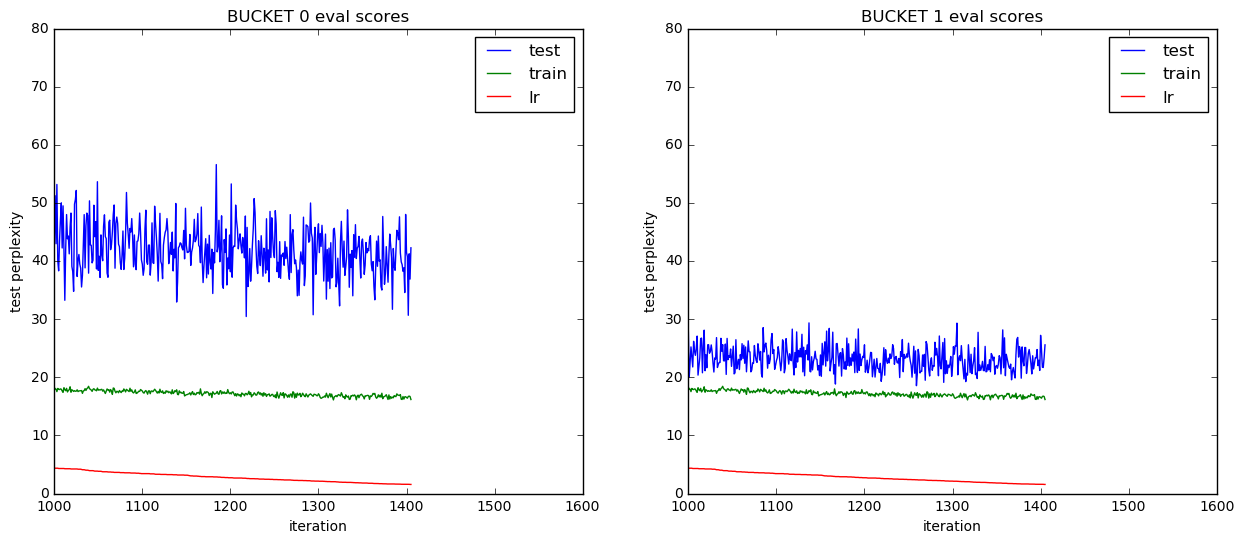

In [34]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(range(len(bucket_scores[0])), bucket_scores[0])
plt.plot(range(len(train_scores)), train_scores)
plt.plot(range(len(learning_rates)), learning_rates*100)
plt.legend(["test", "train", "lr"])
plt.title("BUCKET 0 eval scores")
plt.xlabel("iteration"); plt.ylabel("test perplexity"); plt.ylim((0, 80)); plt.xlim((1000, 1600));

plt.subplot(1,2,2)
plt.plot(range(len(bucket_scores[1])), bucket_scores[1])
plt.plot(range(len(train_scores)), train_scores)
plt.plot(range(len(learning_rates)), learning_rates*100)
plt.legend(["test", "train", "lr"])
plt.title("BUCKET 1 eval scores")
plt.xlabel("iteration"); plt.ylabel("test perplexity"); plt.ylim((0, 80)); plt.xlim((1000, 1600));

153600